# Airbnb Data Modeling

Model predicts airbnb day prices in Seattle to help hosts with pricing using feature engineering, light gradient boosting feature selection and regression. 

In [2600]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.linear_model import Ridge, RidgeCV
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2601]:
df=pd.read_csv("listings_seattle.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,1/4/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,1/4/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,1/4/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,1/4/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,1/4/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Model evaluation function fits training data, predicts and computes score

In [2602]:
def model_eval(X, y, model):
    '''
    input: X is features data frame, y is respones, model
    output: cross validation score, test score, predicted values
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv = 5)
    test_score = r2_score(y_test, y_pred)
    return score, test_score, y_pred, y_test

In [2603]:
num_rows = df.shape[0] #Provide the number of rows in the dataset
num_cols = df.shape[1] #Provide the number of columns in the dataset
print(num_rows)
print(num_cols)
print(df.columns)

3818
92
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'ameni

Columns with nulls

In [2604]:
nulls = set(df.columns[df.isnull().any()])#Provide a set of columns with missing values.
print(nulls)

{'host_location', 'first_review', 'security_deposit', 'review_scores_cleanliness', 'square_feet', 'last_review', 'review_scores_checkin', 'review_scores_communication', 'host_name', 'host_is_superhost', 'host_listings_count', 'host_since', 'medium_url', 'bathrooms', 'host_total_listings_count', 'host_thumbnail_url', 'host_picture_url', 'host_identity_verified', 'beds', 'thumbnail_url', 'reviews_per_month', 'bedrooms', 'host_neighbourhood', 'neighbourhood', 'transit', 'zipcode', 'space', 'host_about', 'summary', 'notes', 'host_response_time', 'host_has_profile_pic', 'host_acceptance_rate', 'review_scores_location', 'xl_picture_url', 'review_scores_value', 'monthly_price', 'host_response_rate', 'license', 'neighborhood_overview', 'weekly_price', 'review_scores_rating', 'property_type', 'cleaning_fee', 'review_scores_accuracy'}


Columns with many missing values

In [2605]:
most_missing_cols = set(df.columns[abs(df.isnull().sum())>0.7*len(df)])
print(most_missing_cols)
df=df.drop(most_missing_cols, axis=1)

{'license', 'square_feet'}


Check distributions of some features

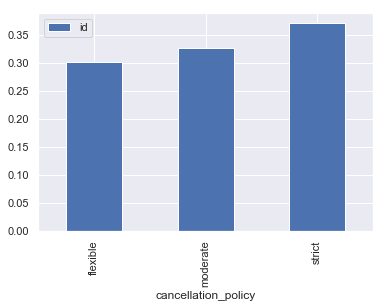

In [2606]:
#print(dfb.cancellation_policy.unique())
dfc=df[['id', 'cancellation_policy']].groupby(['cancellation_policy']).count()
(dfc/df.shape[0]).plot(kind="bar");

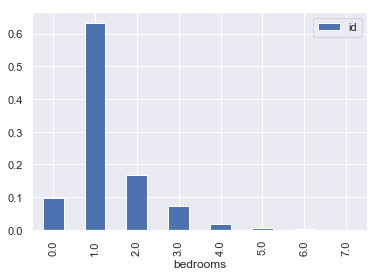

In [2607]:
dfc=df[['id', 'bedrooms']].groupby(['bedrooms']).count()
(dfc/df.shape[0]).plot(kind="bar");

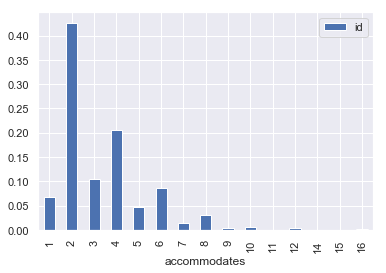

In [2608]:
dfc=df[['id', 'accommodates']].groupby(['accommodates']).count()
(dfc/df.shape[0]).plot(kind="bar")

Possible outcome columns related to price

In [2609]:
out=['price', 'weekly_price', 'monthly_price']

In [2610]:
dfm=df.loc[~df['monthly_price'].isnull()]
print(len(dfm))
dfw=df.loc[~df['weekly_price'].isnull()]
print(len(dfw))
print(len(df.loc[~df['price'].isnull()]))

1517
2009
3818


Preprocess numerical feature

In [2611]:
df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))

In [2612]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%', '')))
print(df.select_dtypes(['float', 'int', 'int64']).columns)
col_reviews=['review_scores_value', 'review_scores_rating',  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']
col_num = ['accommodates', 'host_total_listings_count', 'bedrooms', 'bathrooms', 'beds', 'host_response_rate', 'host_acceptance_rate']
# Mean function
fill_mean = lambda col: col.fillna(int(col.mean()))
# Fill the mean
df[col_num] = df[col_num].apply(fill_mean, axis=0)
for i in col_reviews:
    df[i]=df[i].fillna(0.0)

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')


Numerical features

In [2613]:
#This feature works better (checked) and reduce number of features
df['totalrooms'] = df['bedrooms']+df['bathrooms']
del df['bedrooms']
del df['bathrooms']
colf=df.select_dtypes(['float', 'int', 'int64']).columns
colf =[i for i in colf if i not in ['id','scrape_id']]
print(colf)

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'price', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'totalrooms']


In [2614]:
df["host_total_listings_count"]=df["host_total_listings_count"].fillna(df["host_total_listings_count"].mean())
#print(len(df[df["host_total_listings_count"].isnull()]))


 Heat map to find which features are high correlated and may not be be used all together. We will use light gradient boosting for further features selection. All this will be also checked on final resulst optimization.

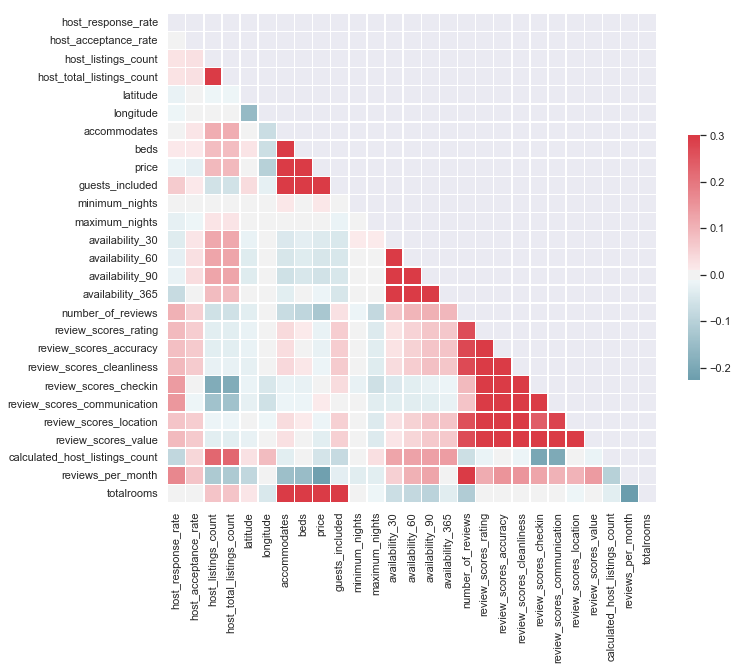

In [2615]:
#first to exclude 
exc=  ['host_id']#['calculated_host_listings_count', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',  'review_scores_cleanliness', 'host_listings_count', "price"]
col = [i for i in colf if i not in exc]
corr = df[col].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Run Light Gradient Boosting on numerical feature to check first numerical feature importance and result for this model

In [2616]:
exc=  ['maximum_nights', 'price']#['calculated_host_listings_count', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',  'review_scores_cleanliness', 'host_listings_count', "price"]

col = [i for i in col if i not in exc]
print(col)
X_num=df[col]
Y=df["price"]
#model
print(len(col))
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#XGBClassifier(max_depth=5, learning_rate=0.01,  sample_weight=w_array)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
score, test_score, y_pred, y_test = model_eval(X_num, Y, model)
print('all')
print('numerical')
print(np.mean(score))
print(test_score)

['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'totalrooms']
25
all
numerical
0.6126829057890181
0.6545509538374099


Plot feature importances…


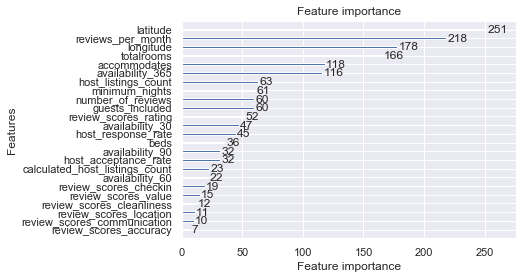

In [2617]:
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=28)
plt.show()

In [2618]:
#remove lowest importance values and some of highly correlated, until we have the best result at the end
exc=  ['maximum_nights', 'price',  'review_scores_cleanliness', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',   "price"]
col = [i for i in colf if i not in exc]
print(col)
X_num=df[col]
Y=df["price"]
#model
print(len(col))
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#XGBClassifier(max_depth=5, learning_rate=0.01,  sample_weight=w_array)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
score, test_score, y_pred, y_test = model_eval(X_num, Y, model)
print('all')
print('numerical')
print(np.mean(score))
print(test_score)

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_checkin', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'totalrooms']
22
all
numerical
0.6145959448918786
0.6491754607318101


Plot feature importances…


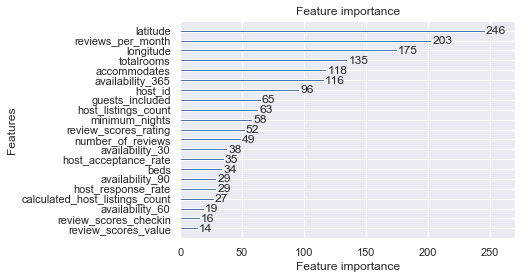

In [2619]:
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=26)
plt.show()

In [2620]:
df=df.drop(['experiences_offered'], axis=1)

Categorical variables

In [2621]:
#print(df['host_is_superhost'])
cat_col = df.select_dtypes(include=['object']).columns
df[cat_col] = df[cat_col].fillna('none')
text=['summary', 'amenities', 'name', 'notes', 'description', 'neighborhood_overview', 'transit', 'host_about']
exclude=['id', 'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col = [i for i in cat_col if i not in out+exclude+text]
print(cat_col)
le  = LabelEncoder()
for i in cat_col:
    df[i]=le.fit_transform(df[i].astype('category'))
X_cat = df[cat_col]           

['host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'smart_location', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy']


all
numerical
0.33948917451100896
0.4249329019360071
Plot feature importances…


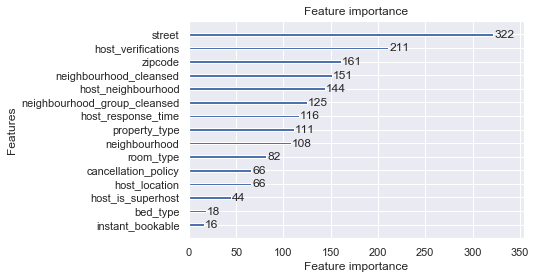

In [2622]:
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=5, learning_rate=0.05)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#cross_val
score, test_score, y_pred, y_test = model_eval(X_cat, Y, model)
print('all')
print('numerical')
print(np.mean(score))
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=26)
plt.show()

All together with lowerst impotance values removed

all
numerical
0.6322168395595626
0.6980699117358069
Plot feature importances…


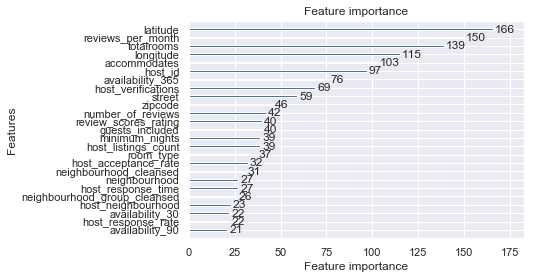

In [2623]:
exclude=['id', 'instant_bookable',  'host_is_superhost',  'bed_type',  'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col =[i for i in cat_col if i not in exclude]
#model
X=df[cat_col+col]
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=5, learning_rate=0.05)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#cross_val
score, test_score, y_pred, y_test = model_eval(X, Y, model)
print('all')
print('numerical')
print(np.mean(score))
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=25)
plt.show()

In [2624]:
count_descp = TfidfVectorizer(max_features = 90, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_am = TfidfVectorizer(max_features = 50, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_transit = TfidfVectorizer(max_features = 50, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_n = TfidfVectorizer(max_features = 20, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_desc = count_descp.fit_transform(df["description"])
X_name = count_descp.fit_transform(df["name"])
X_transit = count_transit.fit_transform(df["transit"])
X_am = count_am.fit_transform(df['amenities'])
X_s = count_n.fit_transform(df['summary'])

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_checkin', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'totalrooms']
all
numerical
0.2834098407365043
0.3818115492534082
0.7115120873625296
Plot feature importances…


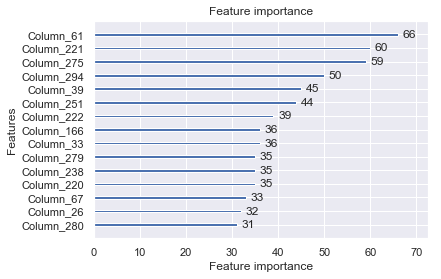

In [2625]:
print(col)
X_desc
X_cat=df[cat_col]
#X_num=df[col]
#X_cat=df[cat_col].astype('category')
#X=np.concatenate((X_num, X_desc),axis =1)
Y=df["price"]
X1=hstack((            
                         X_s,
                         X_am,
                         X_transit,      
                         X_name,
                         X_desc
          )).tocsr()
model1 = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth = 8)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#

# composite model coefficients 
a=0.15
b=0.85

score1, test_score1, ypred1, y_test = model_eval(X1, Y, model1)
#X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)
print('all')
print('numerical')
#print(score)
print(np.mean(score1))
print(test_score1)
y_pred2=a*ypred1+b*y_pred
#y_pred=0.2*model1.predict(X1)+0.8*model.predict(X)
test_score = r2_score(y_test, y_pred2)
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model1, max_num_features=15)
plt.show()